# Emotion Detection using Machine learning algorithm and ECG Dataset

# Introduction 
Nowadays, emotion detection using machine learning algorithm become widely known and became one of the indemand research topic. But recent studies are detection emotion using images, camera, etc. This notebook will try to predict emotions using electrocardiogram readings from public dataset on mendeley. <br>
Dataset Link: [Young Adult's Affective Data (YAAD) Using ECG and GSR Signals](https://data.mendeley.com/datasets/g2p7vwxyn2/4)

## Table of Contents
**1. [Introduction](#introduction)** <br>
**2. [Import Libraries](#import-lib)** <br>
**2. [Data Preprocessing](#data-preprocessing)**<br>
**3. [Explore](#explore)**<br>
**4. [Feature Engineering](#feature-engineering)** <br>
**5. [Split Data](#split-data)**<br>
**6. [Model Building](#model-building)**<br>
**7. [Hyperparameter Tuning](#hyperparameter-tuning)**<br>
**8. [Hyperparameter Tuning Analysis](#hyperparameter-analysis)**

## <a id='import-lib'>Import Libraries </a>

In [1]:
import time
import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt

import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from scipy.stats import boxcox

## <a id='data-preprocessing'>Preprocessing</a>
Preprocessing include the following:
- Clean Data
- Converts .bat file to a list
- Mapped the ECG readings to reference IDs of each participant

In [2]:
def process_raw(raw_data_files: list) -> list:
    '''
        Filters the first 1100 values of ECG readings.
        
        Parameters
        ----------
        raw_data_files: list
            raw data of ECG_readings
        
        Returns
        -------
        ecg_signal_raw: list
            First 1100 values of ECG readings.
    '''
    
    ecg_signal_raw = {}
    for i in raw_data_files:
        file = open(i, 'r')
        ref_name = os.path.basename(i).split('_')[1].split('.')[0]
        for line in file:
            ref_name = ref_name.lower()
            ecg_signal_raw.update({ref_name: line.split(',')})
            ecg_signal_raw.update({ref_name: ecg_signal_raw[ref_name][0:1100]})
            
    return ecg_signal_raw

def convert_raw(df: pd.DataFrame) -> pd.DataFrame:
    '''
        Converts ECG Readings to a list of float
        
        Parameters
        ----------
        df: pandas.DataFrame
        
        Returns
        -------
        df: pandas.DataFrame
            Converted ECG readings in a list.
    
    '''
    
    conv_vals = []
    df['ECG_Signal'] = df['ECG_Signal'].str.replace('[','', regex=False)
    df['ECG_Signal'] = df['ECG_Signal'].str.replace(']','', regex=False)
    df['ECG_Signal'] = df['ECG_Signal'].str.replace("'", '', regex=False)   
    df['ECG_Signal'] = df['ECG_Signal'].str.replace("'", '', regex=False) 
    df['ECG_Signal'] = df['ECG_Signal'].str.replace("\\n", '', regex=False)
    for i in range(len(df)):
        for ind, val in enumerate(df['ECG_Signal'][i].split(',')):
            conv_vals.append(float(val))
        df['ECG_Signal'][i] = conv_vals
        conv_vals = []

    return df
        
def insert_raw(raw_dict: dict, df_dir: str) -> pd.DataFrame:
    '''
        Takes a processed dictionary of ECG readings and map to the reference IDs, and rename columns
        
        Parameters
        ----------
        raw_dict: dict
            raw ECG_readings to be mapped to reference IDs
        df_dir: str
            file directory, where the ECG readings are stored
        
        Returns
        -------
        df_dir: pd.DataFrame
            Returns renamed columns, and mapped raw ECG readings to the respective reference IDs
    '''
    
    new_col_names = ['Participant_ID', 'Session_ID',
                     'Video_ID',
                     'Name',
                     'Age',
                     'Gender',
                     'Valence_Level',
                     'Arousal_Level',
                     'Dominance_Level',
                     'Happy',
                     'Sad',
                     'Fear',
                     'Anger',
                     'Neutral',
                     'Disgust',
                     'Surprised',
                     'Familiarity_Score',
                     'Emotion',
                     'Valence_Label',
                     'Arousal_Label',
                     'Four_Labels']
 
    df = pd.read_csv(df_dir, quotechar="'")
    df.columns = new_col_names
    
    respondents_ref = [df.columns[1][0].lower() + df.loc[i,'Session_ID'].astype('str') +
                   df.columns[0][0].lower() + df.loc[i,'Participant_ID'].astype('str') + 
                   df.columns[2][0].lower() + df.loc[i,'Video_ID'].astype('str')
                   for i in range(len(df))
                  ]
    df['Reference'] = pd.DataFrame(respondents_ref)
    df.set_index('Reference', inplace=True)
    
    i = []
    for key, val in raw_dict.items():
        i.append(key)
        df.loc[key, 'ECG_Signal'] = str(val)

    df.reset_index(inplace=True)
    return df

In [3]:
#locate all files using glob
raw_multi_dir = glob('Datasets/Raw Data/Multimodal/ECG/ECGdata_*.dat')
raw_single_dir = glob('Datasets/Raw Data/Single Modal/ECG/ECGdata_*.dat')
# Retrieved raw ECG readings
processed_multi_raw_data = process_raw(raw_multi_dir)
processed_single_raw_data = process_raw(raw_single_dir)

In [4]:
# Insert ECG readings to the raw csv file
multiM_df = insert_raw(processed_multi_raw_data, 'Datasets/Self-Annotation Labels/Self-annotation Multimodal_Use.csv')
singleM_df = insert_raw(processed_single_raw_data, 'Datasets/Self-Annotation Labels/Self-annotation Single Modal_Use.csv')

In [5]:
# Convert ECG readings to list[float]
main_single_df = convert_raw(singleM_df)
main_multi_df = convert_raw(multiM_df)

C:\Users\rambo\AppData\Local\Temp\ipykernel_5600\3063910840.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ECG_Signal'][i] = conv_vals


In [6]:
# concatenate single modal and multimodal, since we only used ECG readings here
main_data = pd.concat([main_single_df, main_multi_df])

In [7]:
# Reset index, so we have normal index values
main_data.reset_index(inplace=True)
main_data.drop(columns=['index'], inplace = True)

And now the data is now prepare for data analysis

# <a id='explore'> Explore </a>


In [8]:
main_data.head()

,Reference,Participant_ID,Session_ID,Video_ID,Name,Age,Gender,Valence_Level,Arousal_Level,Dominance_Level,...,Anger,Neutral,Disgust,Surprised,Familiarity_Score,Emotion,Valence_Label,Arousal_Label,Four_Labels,ECG_Signal
0,s1p1v1,1,1,1,M_W,21,Female,6,0,0,...,VeryLow,VeryHigh,VeryLow,VeryLow,5,Neutral,HV,LA,HVLA,"[16.51, 16.496, 16.5, 16.492, 16.492, 16.494, ..."
1,s1p1v2,1,1,2,M_W,21,Female,2,4,2,...,VeryHigh,VeryLow,Moderate,Moderate,Never watched,Anger,LV,LA,LVLA,"[16.51, 16.496, 16.5, 16.492, 16.492, 16.494, ..."
2,s1p1v3,1,1,3,M_W,21,Female,7,6,6,...,Low,Moderate,VeryLow,Moderate,Never watched,Mixed,HV,HA,HVHA,"[11.273, 11.265, 11.274, 11.272, 11.269, 11.27..."
3,s1p1v4,1,1,4,M_W,21,Female,7,3,4,...,VeryLow,Low,VeryLow,Low,Never watched,Mixed,HV,LA,HVLA,"[10.049, 10.065, 10.042, 10.008, 10.065, 10.07..."
4,s1p1v5,1,1,5,M_W,21,Female,0,8,8,...,High,VeryLow,VeryHigh,High,Never watched,Disgust,LV,HA,LVHA,"[9.8221, 9.8296, 9.8246, 9.8414, 9.8504, 9.820..."


In [9]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Reference          406 non-null    object
 1   Participant_ID     406 non-null    int64 
 2   Session_ID         406 non-null    int64 
 3   Video_ID           406 non-null    int64 
 4   Name               406 non-null    object
 5   Age                406 non-null    int64 
 6   Gender             406 non-null    object
 7   Valence_Level      406 non-null    int64 
 8   Arousal_Level      406 non-null    object
 9   Dominance_Level    406 non-null    int64 
 10  Happy              406 non-null    object
 11  Sad                406 non-null    object
 12  Fear               406 non-null    object
 13  Anger              406 non-null    object
 14  Neutral            406 non-null    object
 15  Disgust            406 non-null    object
 16  Surprised          406 non-null    object
 1

- `Arousal Level` and `Familiarty Score` should be a number not an object (we will convert the type later on)
- The columns Happy, Sad, Fear, Anger, Neutral, Disgust, Surprised are leaky features
- The valence label, arousal label, and four labels were acquired from valence level, arousal level, and dominance level; so we can treat these as leaky features as well
- Reference, Participant_ID, Session_ID, Video_ID are just reference columns <br>

*The **leaky** features are features in which we do not have access if the model will be deployed*

-------------------------------------------------------------------------------------------------------------------------------
Let's check if we have features with >50% missing values

In [10]:
main_data.isnull().sum() / len(main_data)

Reference            0.00000
Participant_ID       0.00000
Session_ID           0.00000
Video_ID             0.00000
Name                 0.00000
Age                  0.00000
Gender               0.00000
Valence_Level        0.00000
Arousal_Level        0.00000
Dominance_Level      0.00000
Happy                0.00000
Sad                  0.00000
Fear                 0.00000
Anger                0.00000
Neutral              0.00000
Disgust              0.00000
Surprised            0.00000
Familiarity_Score    0.35468
Emotion              0.00000
Valence_Label        0.00000
Arousal_Label        0.00000
Four_Labels          0.00000
ECG_Signal           0.00000
dtype: float64

Only the familiarity Score has missing values but it's also less than 50%, we keep that and we'll impute missing values

-------------------------------------------------------------------------------------------------------------------------------
Now, let's remove the leaky features, and convert the data types of familiary score and arousal level

In [11]:
def wrangle(main_data):
    # create a copy of a dataframe
    df = main_data.copy()
    
    # remove leaky features
    df.drop(columns=['Happy', 'Sad', 'Fear', 'Anger', 
                     'Neutral', 'Disgust', 'Surprised', 
                     'Valence_Label', 'Arousal_Label', 
                     'Four_Labels'], inplace = True)
    
    # remove reference features (these features are high cardinality features)
    df.drop(columns = ['Reference', 'Participant_ID', 'Session_ID',
                     'Video_ID', 'Name'], inplace = True)
    
    # Convert feature to correct dtype 
    df['Arousal_Level'] = df['Arousal_Level'].replace('⁸', 0)
    df['Arousal_Level'] = df['Arousal_Level'].astype('int64')
    
    # Replace never watch to 0
    df['Familiarity_Score'] = df['Familiarity_Score'].replace('Never watched', 0)

    # impute missing values with most frequent
    df.fillna(df['Familiarity_Score'].mode()[0], inplace=True)
    
    # convert familiarity score to integer
    df['Familiarity_Score'] = df['Familiarity_Score'].astype('int64')
    
    # label encode target vector
    label_encode = LabelEncoder() # Instantiate label encoder
    df['Emotion'] = label_encode.fit_transform(df['Emotion']).astype('int64')
    
    return df

main_df = wrangle(main_data)
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                406 non-null    int64 
 1   Gender             406 non-null    object
 2   Valence_Level      406 non-null    int64 
 3   Arousal_Level      406 non-null    int64 
 4   Dominance_Level    406 non-null    int64 
 5   Familiarity_Score  406 non-null    int64 
 6   Emotion            406 non-null    int64 
 7   ECG_Signal         406 non-null    object
dtypes: int64(6), object(2)
memory usage: 25.5+ KB


We can now see that all scores, levels, are now numbers

-------------------------------------------------------------------------------------------------------------------------------
Let's describe data numerical features to see any relevant patterns

In [12]:
main_df.describe()

,Age,Valence_Level,Arousal_Level,Dominance_Level,Familiarity_Score,Emotion
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,13.913793,4.219212,3.551724,2.334975,0.556650,3.455665
std,3.802528,3.453926,3.397317,3.234247,2.168345,1.775486
min,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1.000000,0.000000,0.000000,0.000000,3.000000
50%,13.000000,4.000000,3.000000,0.000000,0.000000,3.000000
75%,14.000000,7.000000,7.000000,4.750000,0.000000,4.000000
max,25.000000,10.000000,9.000000,9.000000,10.000000,7.000000


We can see that there are skewed data, let's visualize

In [13]:
num_feat = main_df.select_dtypes('number')

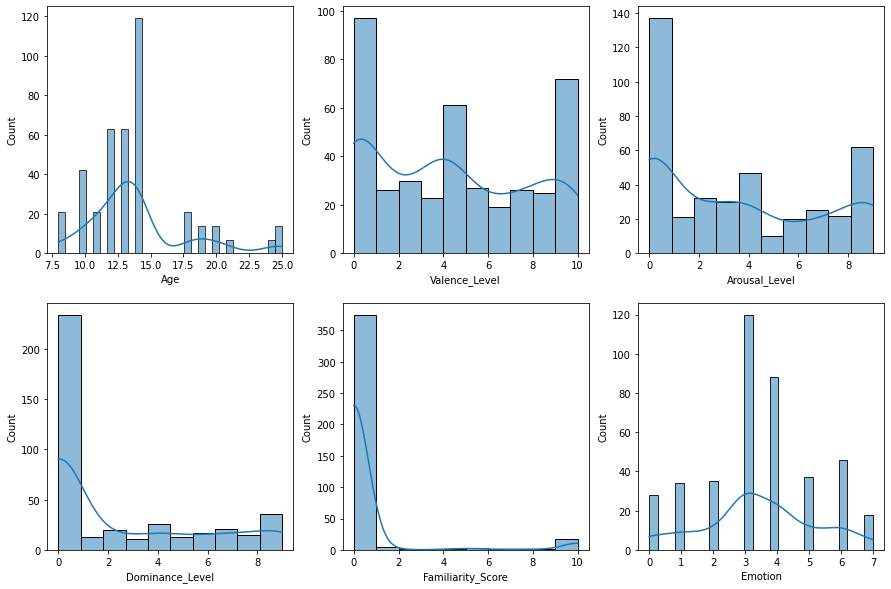

In [14]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    if i < len(num_feat.columns):
        sns.histplot(num_feat.iloc[:, i], kde = True, ax = ax);

- Dominance Level, Age and Familiarity Score are highly skewed
- Valence Level has multimodal and approximately normally distributed
- Arousal level is moderately skewed
- Converted target vector is approximately normally distributed

To check the interpretation, let's compute the skewness value

In [15]:
num_feat.skew().sort_values(ascending=False)

Familiarity_Score    3.894755
Age                  1.232509
Dominance_Level      1.005810
Arousal_Level        0.424298
Valence_Level        0.259636
Emotion             -0.030438
dtype: float64

most interpretation are on point. Familiarity score, age and the dominance level have high skewness. <br>
We can transform all of the highly skewed feature in feature engineering, and let's leave the features with <.50 skewness value

-------------------------------------------------------------------------------------------------------------------------------
**Check relationship of the features to the target**

<AxesSubplot:>

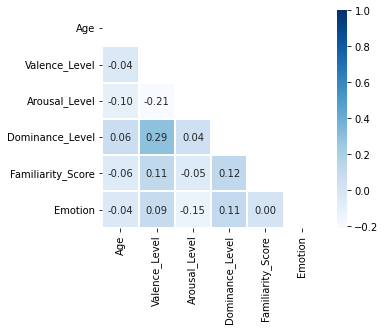

In [16]:
num_feat_target = num_feat.columns.tolist()
corr_matrix = main_df[num_feat_target].corr()
corr_mask = np.triu(np.ones(corr_matrix.shape)) # For readability
sns.heatmap(corr_matrix, square=True, annot=True, linewidths=0.1, fmt='.2f', mask = corr_mask, cmap='Blues', vmax = 1.0)

- **Correlation:** Since the default correlation used here is pearson correlation and pearson is used for continuous, we cannot capture significant correlation.
- **Multicollinearity:** There are also no strong relationship between features, means we cannot sea any relevant multicollinearities<br>
We can use chi2, since chi2 is used to test the independence of two nominal variables or use mutual information. But let's leave it as it is for now*

-------------------------------------------------------------------------------------------------------------------------------
**Visualize Emotion Signals** <br>
Now, let's visualize ECG readings

In [17]:
def plot_signals(data_signal, plot_title):
    plt.figure(figsize=(12, 6))
    for ind, val in data_signal.iteritems():
        plt.plot(val)
    plt.ylabel('ECG_Readings')
    plt.xlabel('Iterations')
    plt.tight_layout()
    plt.title(plot_title)
    plt.show()

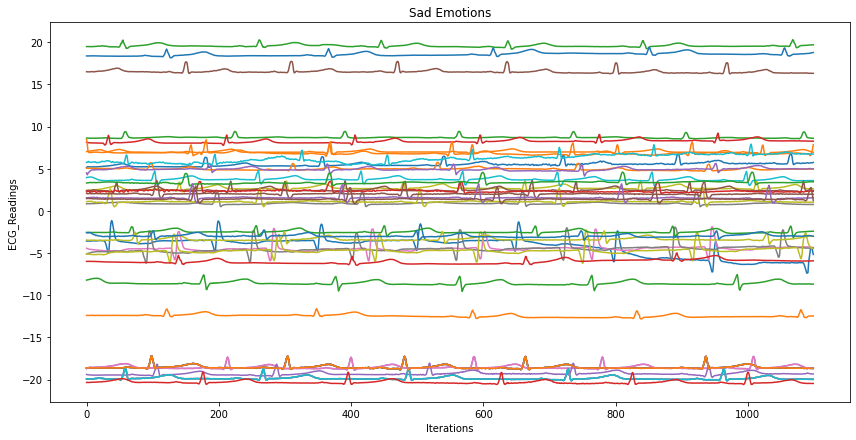

In [18]:
plot_signals(main_data['ECG_Signal'].loc[main_data['Emotion'] == 'Sad'], "Sad Emotions")

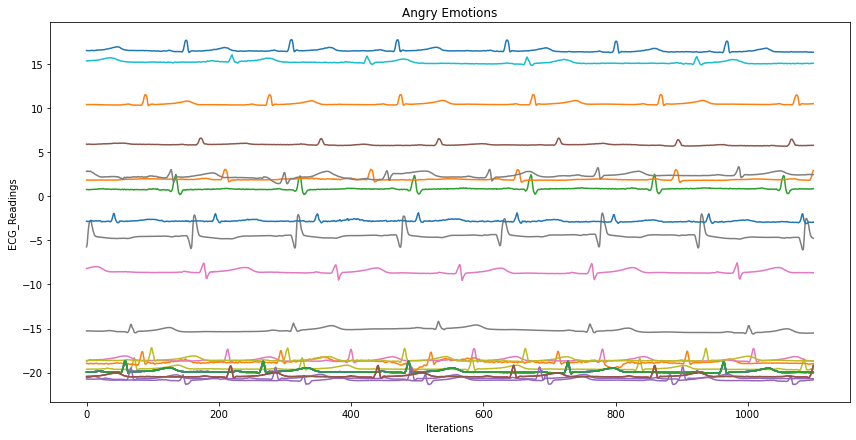

In [19]:
plot_signals(main_data['ECG_Signal'].loc[main_data['Emotion'] == 'Anger'], "Angry Emotions")

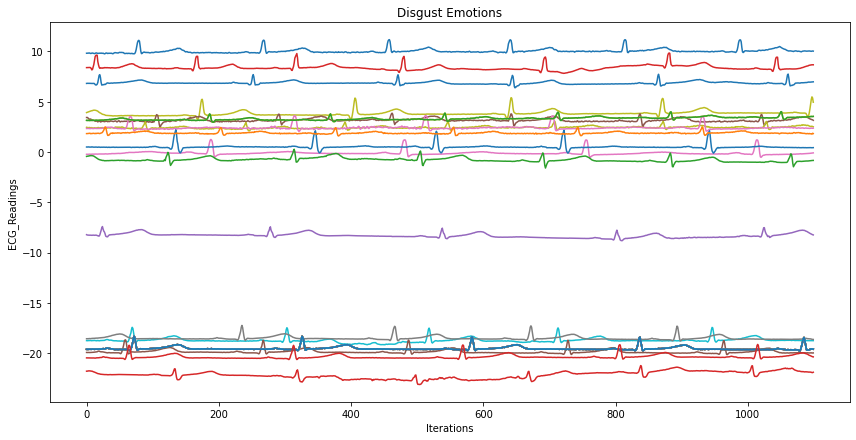

In [20]:
plot_signals(main_data['ECG_Signal'].loc[main_data['Emotion'] == 'Disgust'], "Disgust Emotions")

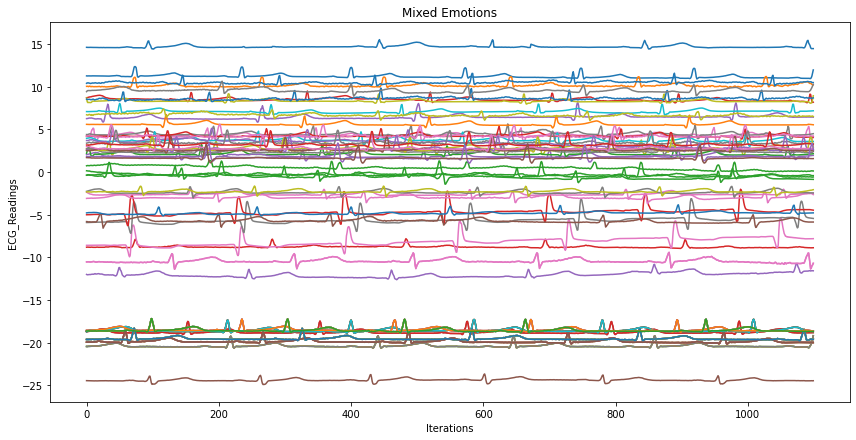

In [21]:
plot_signals(main_data['ECG_Signal'].loc[main_data['Emotion'] == 'Mixed'], "Mixed Emotions")

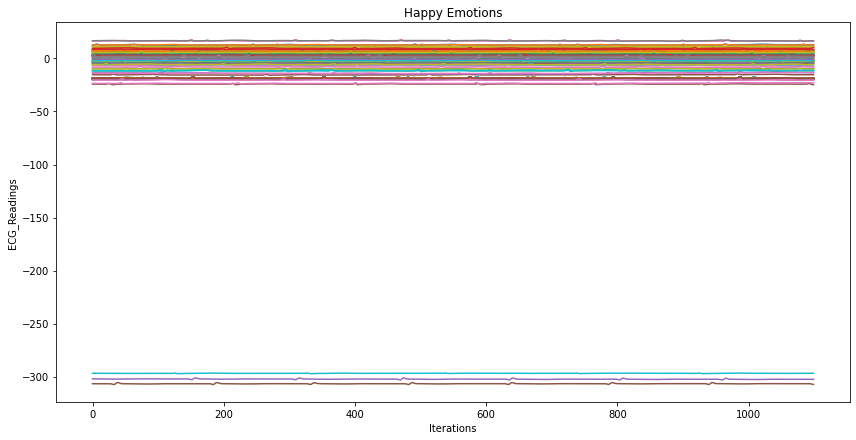

In [22]:
plot_signals(main_data['ECG_Signal'].loc[main_data['Emotion'] == 'Happy'], "Happy Emotions")

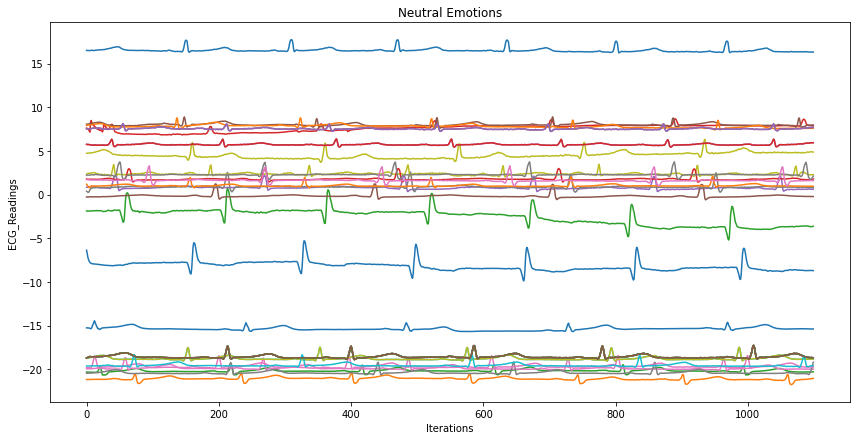

In [23]:
plot_signals(main_data['ECG_Signal'].loc[main_data['Emotion'] == 'Neutral'], "Neutral Emotions")

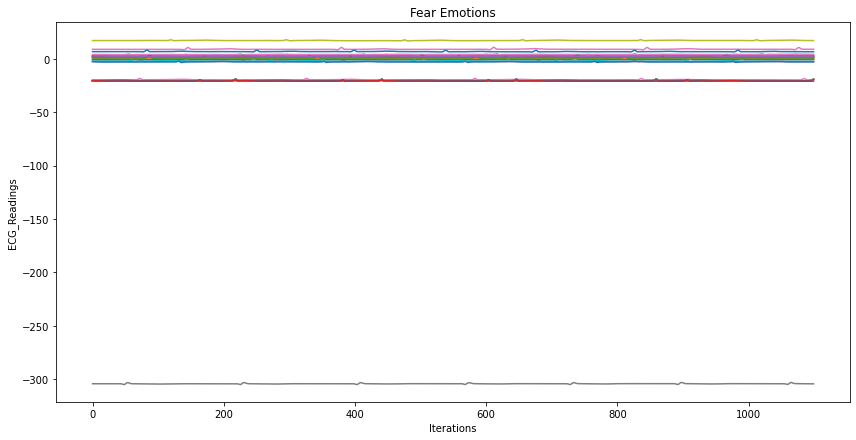

In [24]:
plot_signals(main_data['ECG_Signal'].loc[main_data['Emotion'] == 'Fear'], "Fear Emotions")

*We only have 1100 readings since we only get the first 1100 readings in the preprocessing*

**Fear Emotion**: 
- Majority of the readings are around 50 to -50
- has an outlier, we can remove this since this would affect the distribution of our ECG readings

**Happy Emotion**: 
- Majority of the readings are around 20 to < -50
- There are outliers, we can remove this since this would affect the distribution of our ECG readings

**Neutral, Angry, and Disgust Emotions**:
- ECG readings are only from 15 to -20

**Mixed Emotion**:
- There are inconsistencies on the readings, expected since all emotions are mixed together

Let's remove outliers in `Feature Engineering` Section

---------------------------------------------------------------------------------------------------------------------------
# <a id='feature-engineering'> Feature Engineering </a>
We will do the following:
- Transform skewed features (Age, and Dominance_Level)
- Get 10 means of 1100 ECG readings to use as features
- OneHotEncode Gender

In [25]:
# oh_encoder = OneHotEncoder(use_cat_names = True)

# gender_df = pd.DataFrame(encoder.fit_transform(main_data[['Gender']]).toarray())
# main_data = main_data.join(gender_df).drop(columns=['Gender'])
# main_data.rename(columns={0: "GenderFemale", 1: "GenderMale"}, inplace=True)
# main_data = main_data[['Age','Valence_Level','Arousal_Level',
#                    'Dominance_Level','GenderFemale','GenderMale','ECG_Signal',
#                    'Emotion']]
# main_data.head()

In [26]:
transform_cols = ['Age', 'Dominance_Level']
for cols in transform_cols:
    main_df[cols] = np.log1p(main_df[cols])
main_df.skew()

C:\Users\rambo\AppData\Local\Temp\ipykernel_5600\1056401290.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  main_df.skew()


Age                  0.505033
Valence_Level        0.259636
Arousal_Level        0.424298
Dominance_Level      0.602014
Familiarity_Score    3.894755
Emotion             -0.030438
dtype: float64

Now, we can see that the skewness has been reduced

*We didn't transform Familiarity level since the majority of the Familiarity score is 0 (Never Watched)*

-------------------------------------------------------------------------------------------------------------------------------
Let's compute 10 means to use as features from ECG readings list

In [27]:
def get_ave(x: list) -> list:
    '''
        Computes ten (10) average of 1100 length ECG readings in sequence.
        
        Parameters
        ----------
        x : list
            length should be equal to 1100.
            if true, returns list of average;
            if false, raises IndexError.
        
        Returns
        -------
        average: list
            Computed averages from 1100 ECG readings .
    '''
    if len(x) != 1100:
        raise IndexError("the length of the list should be equal to 1000")
    
    average = []
    k = 0
    m = 0
    for i, j in enumerate(x):
        if i % 100 == 0 and i != 0:
            average.append(sum(x[k:i])/len(x[k:i]))
            k+=100
    return average

In [28]:
main_df['ECG_Signal'] = main_df['ECG_Signal'].apply(get_ave)
main_df_ECG = main_df['ECG_Signal'].astype('str').str.split(',', expand = True).rename(
    columns = {
    0:'Mean_0', 
    1:'Mean_1',
    2:'Mean_2',
    3:'Mean_3',
    4:'Mean_4',
    5:'Mean_5',
    6:'Mean_6',
    7:'Mean_7',
    8:'Mean_8',
    9:'Mean_9',}
)

In [29]:
main_data = pd.concat([main_df, main_df_ECG], axis = 1).drop(columns='ECG_Signal')
main_data.head()

,Age,Gender,Valence_Level,Arousal_Level,Dominance_Level,Familiarity_Score,Emotion,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9
0,3.091042,Female,6,0,0.000000,5,5,[16.596819999999997,16.533289999999997,16.517100000000003,16.63268,16.551610000000004,16.564389999999992,16.585279999999997,16.395110000000003,16.495000000000005,16.423710000000003]
1,3.091042,Female,2,4,1.098612,0,0,[16.596819999999997,16.533289999999997,16.517100000000003,16.63268,16.551610000000004,16.564389999999992,16.585279999999997,16.395110000000003,16.495000000000005,16.423710000000003]
2,3.091042,Female,7,6,1.945910,0,4,[11.312379999999996,11.321159999999999,11.342379999999999,11.209919999999997,11.27546,11.176870000000003,11.20503999999999,11.157299999999998,11.09861,11.20241]
3,3.091042,Female,7,3,1.609438,0,4,[10.080725999999997,10.119419,10.083285999999998,10.130743999999998,10.144701000000003,10.130262000000002,10.198203,10.116810000000003,10.229575,10.064668999999999]
4,3.091042,Female,0,8,2.197225,0,1,[9.903618,9.982182000000003,9.965959000000003,10.01906300000001,10.028688000000002,10.051224000000003,10.096954,10.042476999999998,10.173523999999995,10.053447999999996]


In [30]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                406 non-null    float64
 1   Gender             406 non-null    object 
 2   Valence_Level      406 non-null    int64  
 3   Arousal_Level      406 non-null    int64  
 4   Dominance_Level    406 non-null    float64
 5   Familiarity_Score  406 non-null    int64  
 6   Emotion            406 non-null    int64  
 7   Mean_0             406 non-null    object 
 8   Mean_1             406 non-null    object 
 9   Mean_2             406 non-null    object 
 10  Mean_3             406 non-null    object 
 11  Mean_4             406 non-null    object 
 12  Mean_5             406 non-null    object 
 13  Mean_6             406 non-null    object 
 14  Mean_7             406 non-null    object 
 15  Mean_8             406 non-null    object 
 16  Mean_9             406 non

We can see that the dtype of the means are incorrect, let's convert it to float

In [31]:
#Remove Extra Characters
main_data['Mean_0'] = main_data['Mean_0'].str.replace('[', '', regex=False)
main_data['Mean_9'] = main_data['Mean_9'].str.replace(']', '', regex=False)

In [32]:
obj_cols = main_data.select_dtypes('object').columns.tolist()
mean_cols = [col for col in obj_cols if col!='Gender']
main_data[mean_cols] = main_data[mean_cols].apply(pd.to_numeric)

In [33]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                406 non-null    float64
 1   Gender             406 non-null    object 
 2   Valence_Level      406 non-null    int64  
 3   Arousal_Level      406 non-null    int64  
 4   Dominance_Level    406 non-null    float64
 5   Familiarity_Score  406 non-null    int64  
 6   Emotion            406 non-null    int64  
 7   Mean_0             406 non-null    float64
 8   Mean_1             406 non-null    float64
 9   Mean_2             406 non-null    float64
 10  Mean_3             406 non-null    float64
 11  Mean_4             406 non-null    float64
 12  Mean_5             406 non-null    float64
 13  Mean_6             406 non-null    float64
 14  Mean_7             406 non-null    float64
 15  Mean_8             406 non-null    float64
 16  Mean_9             406 non

All means are now float dtypes, let's locate outlier readings in our data, and remove that

In [34]:
main_data.describe()

,Age,Valence_Level,Arousal_Level,Dominance_Level,Familiarity_Score,Emotion,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,2.673218,4.219212,3.551724,0.748697,0.556650,3.455665,-10.562019,-10.575253,-10.574029,-10.572185,-10.584727,-10.576600,-10.580159,-10.588113,-10.588212,-10.586400
std,0.236587,3.453926,3.397317,0.931596,2.168345,1.775486,31.399570,31.399422,31.402012,31.401639,31.404538,31.403558,31.405376,31.403295,31.403233,31.405506
min,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,-306.728300,-306.647900,-306.734900,-306.701400,-306.624200,-306.716200,-306.674300,-306.598600,-306.682800,-306.639300
25%,2.564949,1.000000,0.000000,0.000000,0.000000,3.000000,-18.723310,-18.768470,-18.750320,-18.767170,-18.770000,-18.806220,-18.709410,-18.823570,-18.745050,-18.796700
50%,2.639057,4.000000,3.000000,0.000000,0.000000,3.000000,-8.455182,-8.597139,-8.445122,-8.513432,-8.450417,-8.564698,-8.501718,-8.636378,-8.489078,-8.562249
75%,2.708050,7.000000,7.000000,1.746179,0.000000,4.000000,2.537743,2.501368,2.539279,2.496404,2.534081,2.485012,2.520146,2.530897,2.482362,2.543381
max,3.258097,10.000000,9.000000,2.302585,10.000000,7.000000,19.566550,19.628660,19.578910,19.704120,19.587680,19.511910,19.572870,19.511420,19.591930,19.550110


we can clearly see the -300 minimum readings, let's locate and remove them

In [35]:
#Count the total number observations with less than -200 readings as a threshhold
(main_data[['Mean_0', 'Mean_1', 'Mean_2', 'Mean_3', 'Mean_4', 'Mean_5', 'Mean_6', 'Mean_7', 'Mean_8', 'Mean_9']] < -200).sum()

Mean_0    4
Mean_1    4
Mean_2    4
Mean_3    4
Mean_4    4
Mean_5    4
Mean_6    4
Mean_7    4
Mean_8    4
Mean_9    4
dtype: int64

We have 4 observations we need to remove, let's remove those observations

In [36]:
# since mean columns have the same values, let's just use one column to remove those data
main_data = main_data[main_data['Mean_0']> - 200]

In [37]:
main_data.describe()

,Age,Valence_Level,Arousal_Level,Dominance_Level,Familiarity_Score,Emotion,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,2.673386,4.189055,3.549751,0.740374,0.562189,3.462687,-7.656633,-7.670385,-7.668599,-7.666955,-7.679649,-7.671319,-7.674763,-7.683019,-7.683091,-7.681077
std,0.237740,3.448095,3.402180,0.927913,2.178417,1.782388,11.692322,11.704995,11.697803,11.701869,11.713665,11.705745,11.707755,11.709876,11.708899,11.710012
min,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,-24.452080,-24.393910,-24.440210,-24.345310,-24.315080,-24.352650,-24.257050,-24.376370,-24.317040,-24.426790
25%,2.564949,1.000000,0.000000,0.000000,0.000000,3.000000,-18.723310,-18.768470,-18.750320,-18.767170,-18.770000,-18.806220,-18.709410,-18.823570,-18.745050,-18.796700
50%,2.639057,4.000000,3.000000,0.000000,0.000000,3.000000,-8.079230,-8.070228,-8.104878,-8.019529,-8.243942,-8.162852,-8.319308,-8.414315,-8.295068,-8.287110
75%,2.708050,7.000000,7.000000,1.609438,0.000000,4.750000,2.552318,2.529815,2.555392,2.539187,2.539563,2.495643,2.527909,2.582656,2.516946,2.569689
max,3.258097,10.000000,9.000000,2.302585,10.000000,7.000000,19.566550,19.628660,19.578910,19.704120,19.587680,19.511910,19.572870,19.511420,19.591930,19.550110


The outliers are now removed and we have remaining 402 observations. In addition, we can observed that the means are approximately normally distributed

-------------------------------------------------------------------------------------------------------------------------------
Now, We only have one object, and that is the Gender. Let's OneHotEncode the Gender

In [38]:
oh_encoder = OneHotEncoder(use_cat_names = True)
oh_encoded_gender = oh_encoder.fit_transform(main_data['Gender'])
oh_encoded_gender

,Gender_Female,Gender_Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
401,0,1
402,0,1
403,0,1
404,0,1


In [39]:
main_data_copy = main_data.copy()
main_data = pd.concat([main_data_copy, oh_encoded_gender], axis = 1).drop(columns = 'Gender')

In [40]:
main_data

,Age,Valence_Level,Arousal_Level,Dominance_Level,Familiarity_Score,Emotion,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9,Gender_Female,Gender_Male
0,3.091042,6,0,0.000000,5,5,16.596820,16.533290,16.517100,16.632680,16.551610,16.564390,16.585280,16.395110,16.495000,16.423710,1,0
1,3.091042,2,4,1.098612,0,0,16.596820,16.533290,16.517100,16.632680,16.551610,16.564390,16.585280,16.395110,16.495000,16.423710,1,0
2,3.091042,7,6,1.945910,0,4,11.312380,11.321160,11.342380,11.209920,11.275460,11.176870,11.205040,11.157300,11.098610,11.202410,1,0
3,3.091042,7,3,1.609438,0,4,10.080726,10.119419,10.083286,10.130744,10.144701,10.130262,10.198203,10.116810,10.229575,10.064669,1,0
4,3.091042,0,8,2.197225,0,1,9.903618,9.982182,9.965959,10.019063,10.028688,10.051224,10.096954,10.042477,10.173524,10.053448,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2.484907,4,9,0.000000,0,4,-10.561340,-10.354494,-10.503090,-10.294761,-10.471061,-10.321367,-10.501792,-10.331752,-10.505442,-10.320241,0,1
402,2.484907,4,0,0.000000,0,3,-11.525630,-11.299740,-11.504890,-11.315460,-11.442090,-11.314660,-11.482100,-11.206440,-11.419840,-11.337070,0,1
403,2.484907,4,0,0.000000,0,4,9.684017,9.592650,9.753063,9.440098,9.486999,9.331860,9.577323,9.507183,9.512714,9.586561,0,1
404,2.484907,2,7,1.098612,0,0,2.260269,2.308163,2.023845,2.265387,2.235197,2.335267,2.366612,2.337513,2.480275,2.393392,0,1


And these are the data we're going to use to predict the emotions

## <a id='split-data'> Split Data </a>

In [41]:
target = 'Emotion'
X = main_data.drop(columns = target)
y = main_data[target]

In [42]:
X.head()

,Age,Valence_Level,Arousal_Level,Dominance_Level,Familiarity_Score,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9,Gender_Female,Gender_Male
0,3.091042,6,0,0.000000,5,16.596820,16.533290,16.517100,16.632680,16.551610,16.564390,16.585280,16.395110,16.495000,16.423710,1,0
1,3.091042,2,4,1.098612,0,16.596820,16.533290,16.517100,16.632680,16.551610,16.564390,16.585280,16.395110,16.495000,16.423710,1,0
2,3.091042,7,6,1.945910,0,11.312380,11.321160,11.342380,11.209920,11.275460,11.176870,11.205040,11.157300,11.098610,11.202410,1,0
3,3.091042,7,3,1.609438,0,10.080726,10.119419,10.083286,10.130744,10.144701,10.130262,10.198203,10.116810,10.229575,10.064669,1,0
4,3.091042,0,8,2.197225,0,9.903618,9.982182,9.965959,10.019063,10.028688,10.051224,10.096954,10.042477,10.173524,10.053448,1,0


In [43]:
y.head()

0    5
1    0
2    4
3    4
4    1
Name: Emotion, dtype: int64

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [45]:
print(f'The shape of X train is {X_train.shape}')
print(f'The shape of X val is {X_val.shape}')
print(f'The shape of y train is {y_train.shape}')
print(f'The shape of y val is  is {y_val.shape}')

The shape of X train is (321, 17)
The shape of X val is (81, 17)
The shape of y train is (321,)
The shape of y val is  is (81,)


Not let's check if the classess are balanced

<AxesSubplot:>

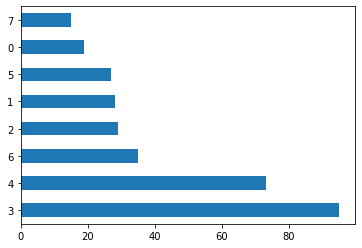

In [46]:
y_train.value_counts().plot(kind = 'barh')

we have an imbalanced dataset, let's use oversampling to balanced all data 

In [47]:
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

In [48]:
X_train_over

,Age,Valence_Level,Arousal_Level,Dominance_Level,Familiarity_Score,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9,Gender_Female,Gender_Male
0,3.258097,0,0,0.000000,0,-19.533720,-19.454150,-19.589710,-19.424080,-19.578270,-19.552550,-19.467970,-19.606360,-19.496520,-19.558680,0,1
1,2.564949,0,9,2.302585,0,-19.533720,-19.454150,-19.589710,-19.424080,-19.578270,-19.552550,-19.467970,-19.606360,-19.496520,-19.558680,1,0
2,2.639057,2,7,1.098612,0,-19.835400,-19.775050,-19.858570,-19.781340,-19.883020,-19.799210,-19.959080,-19.801090,-19.928610,-19.911970,0,1
3,2.397895,0,9,0.000000,0,-20.338410,-20.466110,-20.274490,-20.439290,-20.349170,-20.375860,-20.363760,-20.367220,-20.389540,-20.324940,0,1
4,2.708050,1,4,0.000000,0,-18.561180,-18.423850,-18.619500,-18.431720,-18.585230,-18.523310,-18.587470,-18.523080,-18.647130,-18.477280,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2.397895,9,9,2.302585,0,0.912246,0.891380,0.921612,0.897544,0.889344,0.890894,0.891166,0.865475,0.880871,0.874588,0,1
756,2.708050,1,1,1.386294,0,-20.338410,-20.466110,-20.274490,-20.439290,-20.349170,-20.375860,-20.363760,-20.367220,-20.389540,-20.324940,1,0
757,2.564949,9,9,2.302585,0,5.351243,5.301260,5.231835,5.176435,5.204665,5.155162,5.211127,5.187823,5.239795,5.184113,1,0
758,2.564949,9,9,2.302585,0,5.351243,5.301260,5.231835,5.176435,5.204665,5.155162,5.211127,5.187823,5.239795,5.184113,1,0


Now the rows are 760, let's graph the y_train to see if the classess are now balanced

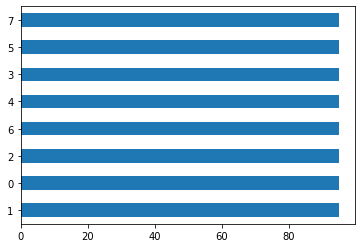

In [49]:
y_train_over.value_counts().plot(kind = 'barh');

We now have a balanced dataset, this split is our final X, y training data

---------------------------------------------------------------------------------------------------------------------------
# <a id='model-building'> Machine Learning Model Building</a>

In [50]:
@ignore_warnings(category=ConvergenceWarning)
def get_metrics(model):
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_val)
    cross_val_scores = cross_validate(
        model, X_train, y_train, cv = 5, 
        scoring = [
            'accuracy', 'f1_macro', 'f1_weighted', 
        ]
    )
    return cross_val_scores

In [51]:
logreg = LogisticRegression(random_state = 42)
log_reg_scores = get_metrics(logreg)

KNClass = KNeighborsClassifier()
KN_scores = get_metrics(KNClass)

DTClass = DecisionTreeClassifier(random_state = 42)
DT_scores = get_metrics(DTClass)

RFClass = RandomForestClassifier(random_state = 42)
RF_scores = get_metrics(RFClass)

GBClass = GradientBoostingClassifier(random_state = 42)
GB_scores = get_metrics(GBClass)

# XGBClass = XGBClassifier()
# get_metrics(XGBClass)

# CBClass = CatBoostClassifier()
# get_metrics(CBClass)

In [52]:
list_ml_algo = ['LogisticRegression', 
                'KNeighbor', 
                'DecisionTree',
                'RandomForest', 
                'GradientBoost'
               ]

def make_df_scores(ml_algorithm, ml_scores):
    df = pd.DataFrame(
        {
            'Machine Learning Algorithm': ml_algorithm,
            'Fold_Number': range(1, 6),
            'fit_time': ml_scores['fit_time'], 
            'score_time': ml_scores['score_time'], 
            'test_accuracy': ml_scores['test_accuracy'],
            'test_f1_macro': ml_scores['test_f1_macro'] ,
            'test_f1_weighted': ml_scores['test_f1_weighted']
        }
    )
    
    return df


scores = [log_reg_scores, KN_scores, DT_scores, RF_scores, GB_scores]

df_score = [make_df_scores(list_ml_algo[i], scores[i]) for i in range(len(scores))]
df_scores = pd.concat(df_score).reset_index().drop(columns='index')
df_scores

,Machine Learning Algorithm,Fold_Number,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_weighted
0,LogisticRegression,1,0.107008,0.002990,0.430769,0.224799,0.365092
1,LogisticRegression,2,0.022002,0.002999,0.437500,0.246245,0.382530
2,LogisticRegression,3,0.020001,0.002998,0.406250,0.203737,0.345263
3,LogisticRegression,4,0.020965,0.003036,0.406250,0.206250,0.344531
4,LogisticRegression,5,0.019999,0.003003,0.375000,0.165262,0.319677
5,KNeighbor,1,0.002014,0.015961,0.415385,0.271751,0.395806
6,KNeighbor,2,0.002000,0.019039,0.421875,0.277913,0.384909
7,KNeighbor,3,0.002994,0.016006,0.359375,0.215344,0.307341
8,KNeighbor,4,0.001030,0.017962,0.453125,0.295327,0.407067
9,KNeighbor,5,0.002015,0.017987,0.468750,0.299250,0.426723


In [53]:
df_scores.groupby('Machine Learning Algorithm').mean().drop(columns='Fold_Number')

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_weighted
Machine Learning Algorithm,,,,,
DecisionTree,0.004194,0.003998,0.404952,0.330286,0.407250
GradientBoost,0.723401,0.003591,0.448702,0.345102,0.437824
KNeighbor,0.002011,0.017391,0.423702,0.271917,0.384369
LogisticRegression,0.037995,0.003005,0.411154,0.209259,0.351418
RandomForest,0.144207,0.014394,0.448798,0.330146,0.431341


The best performing algorithm if we look at the accuracy is GradientBoost, but RandomForest is better if look at `fit_time`
So we conclude that RandomForest is the best performing algorithm with an average of 45%

---------------------------------------------------------------------------------------------------------------------------
# <a id='hyperparameter-tuning'> Hyper Parameter Tuning </a>

Now, let's conduct hyperparameter tuning to see if we can still improve the model scores

In [54]:
def tune_params(clf, params):
    final_model = GridSearchCV(
        clf, 
        param_grid=params,
        cv =5,
        scoring = ['accuracy', 'f1_macro', 'f1_weighted'],
        refit = 'accuracy',
        n_jobs = -1, 
        verbose = 1
    )
    starting_time = time.time()
    final_model.fit(X_train_over, y_train_over)
    ending_time = time.time()
    
    elapse_time = ending_time - starting_time
    return final_model, elapse_time

max_depth = range(10, 151, 10)
n_estimators = range(100, 1000, 100)

logistic_params = {
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'multi_class': ['ovr', 'multinomial'],
    'class_weight': [None, 'balanced']
}
k_neighbors_params = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform','distance'],
    'leaf_size': range(1, 51, 10)
}
decision_tree_params = {
    'splitter': ['best', 'random'],
    'max_depth': max_depth
}
random_forest_params = {
    'n_estimators': n_estimators,
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': max_depth
}
grad_boost_params = {
    'n_estimators': n_estimators,
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'criterion': ['friedman_mse', 'squared_error', 'mse'],
    'max_depth': max_depth
}

log_final_model, log_training_time = tune_params(LogisticRegression(random_state = 42), logistic_params)
KN_final_model, KN_training_time = tune_params(KNeighborsClassifier(), k_neighbors_params)
DT_final_model, DT_training_time = tune_params(DecisionTreeClassifier(random_state = 42), decision_tree_params)
RF_final_model, RF_training_time = tune_params(RandomForestClassifier(random_state = 42), random_forest_params)
GB_final_model, GB_training_time = tune_params(GradientBoostingClassifier(random_state = 42), grad_boost_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 290 candidates, totalling 1450 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Fitting 5 folds for each of 2025 candidates, totalling 10125 fits


In [55]:
print(f'Logistic Regression training time is : {log_training_time}')
print(f'K Neighbors training time is : {KN_training_time}')
print(f'Decision tree training time is : {DT_training_time}')
print(f'Random Forest training time is : {RF_training_time}')
print(f'Gradient Boost training time is : {GB_training_time}')

Logistic Regression training time is : 7.384995698928833
K Neighbors training time is : 3.7869958877563477
Decision tree training time is : 0.36299991607666016
Random Forest training time is : 480.5055387020111
Gradient Boost training time is : 12441.87063074112


Since boosting has a lot of parameters and it is improving a weak learning model in an interative process, the boosting algorithm is expected to be slowest.

## <a id='hyperparameter-analysis'> Hyperparameter tuning analysis </a>

### Logistic Regression

In [56]:
pd.set_option('display.max_columns', None)
log_cv_results = pd.DataFrame(log_final_model.cv_results_).sort_values(by='rank_test_accuracy')
log_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_multi_class,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
3,0.523592,0.062819,0.008399,0.001356,None,multinomial,newton-cg,"{'class_weight': None, 'multi_class': 'multino...",0.513158,0.486842,0.421053,0.519737,0.460526,0.480263,0.036274,1,0.496677,0.476318,0.399213,0.509121,0.447738,0.465813,0.039245,1,0.496677,0.476318,0.399213,0.509121,0.447738,0.465813,0.039245,1
9,0.453200,0.025288,0.006001,0.001899,balanced,multinomial,newton-cg,"{'class_weight': 'balanced', 'multi_class': 'm...",0.513158,0.486842,0.421053,0.519737,0.460526,0.480263,0.036274,1,0.496677,0.476318,0.399213,0.509121,0.447738,0.465813,0.039245,1,0.496677,0.476318,0.399213,0.509121,0.447738,0.465813,0.039245,1
1,0.496801,0.227684,0.010006,0.002287,None,ovr,lbfgs,"{'class_weight': None, 'multi_class': 'ovr', '...",0.506579,0.440789,0.407895,0.486842,0.447368,0.457895,0.034961,3,0.481704,0.419136,0.398349,0.466920,0.427019,0.438626,0.030962,4,0.481704,0.419136,0.398349,0.466920,0.427019,0.438626,0.030962,4
0,0.293421,0.129141,0.004999,0.002535,None,ovr,newton-cg,"{'class_weight': None, 'multi_class': 'ovr', '...",0.493421,0.453947,0.421053,0.480263,0.434211,0.456579,0.027158,4,0.471403,0.439380,0.410747,0.461496,0.410397,0.438685,0.025187,3,0.471403,0.439380,0.410747,0.461496,0.410397,0.438685,0.025187,3
7,0.390627,0.049337,0.007569,0.001053,balanced,ovr,lbfgs,"{'class_weight': 'balanced', 'multi_class': 'o...",0.486842,0.427632,0.388158,0.486842,0.440789,0.446053,0.037540,5,0.466672,0.414341,0.369206,0.472268,0.429311,0.430359,0.037609,5,0.466672,0.414341,0.369206,0.472268,0.429311,0.430359,0.037609,5


In [57]:
log_final_model.best_params_

{'class_weight': None, 'multi_class': 'multinomial', 'solver': 'newton-cg'}

### Knn Classifier

In [58]:
KN_cv_results = pd.DataFrame(KN_final_model.cv_results_).sort_values(by='rank_test_accuracy')

In [59]:
KN_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
179,0.004800,0.001167,0.008999,0.000634,31,3,distance,"{'leaf_size': 31, 'n_neighbors': 3, 'weights':...",0.809211,0.894737,0.855263,0.861842,0.927632,0.869737,0.03978,1,0.796088,0.882830,0.841265,0.848421,0.917959,0.857312,0.041022,1,0.796088,0.882830,0.841265,0.848421,0.917959,0.857312,0.041022,1
63,0.011204,0.009577,0.012000,0.003040,11,3,distance,"{'leaf_size': 11, 'n_neighbors': 3, 'weights':...",0.809211,0.894737,0.855263,0.861842,0.927632,0.869737,0.03978,1,0.796088,0.882830,0.841265,0.848421,0.917959,0.857312,0.041022,1,0.796088,0.882830,0.841265,0.848421,0.917959,0.857312,0.041022,1
183,0.006200,0.002926,0.013399,0.005463,31,5,distance,"{'leaf_size': 31, 'n_neighbors': 5, 'weights':...",0.789474,0.868421,0.875000,0.868421,0.947368,0.869737,0.05000,1,0.771570,0.853051,0.860119,0.855956,0.941506,0.856440,0.053786,11,0.771570,0.853051,0.860119,0.855956,0.941506,0.856440,0.053786,11
121,0.004200,0.000399,0.009598,0.000801,21,3,distance,"{'leaf_size': 21, 'n_neighbors': 3, 'weights':...",0.809211,0.894737,0.855263,0.861842,0.927632,0.869737,0.03978,1,0.796088,0.882830,0.841265,0.848421,0.917959,0.857312,0.041022,1,0.796088,0.882830,0.841265,0.848421,0.917959,0.857312,0.041022,1
9,0.003601,0.000490,0.008400,0.000801,1,5,distance,"{'leaf_size': 1, 'n_neighbors': 5, 'weights': ...",0.789474,0.868421,0.875000,0.868421,0.947368,0.869737,0.05000,1,0.771570,0.853051,0.860119,0.855956,0.941506,0.856440,0.053786,11,0.771570,0.853051,0.860119,0.855956,0.941506,0.856440,0.053786,11


Let's see visualization below to see why these are the best params

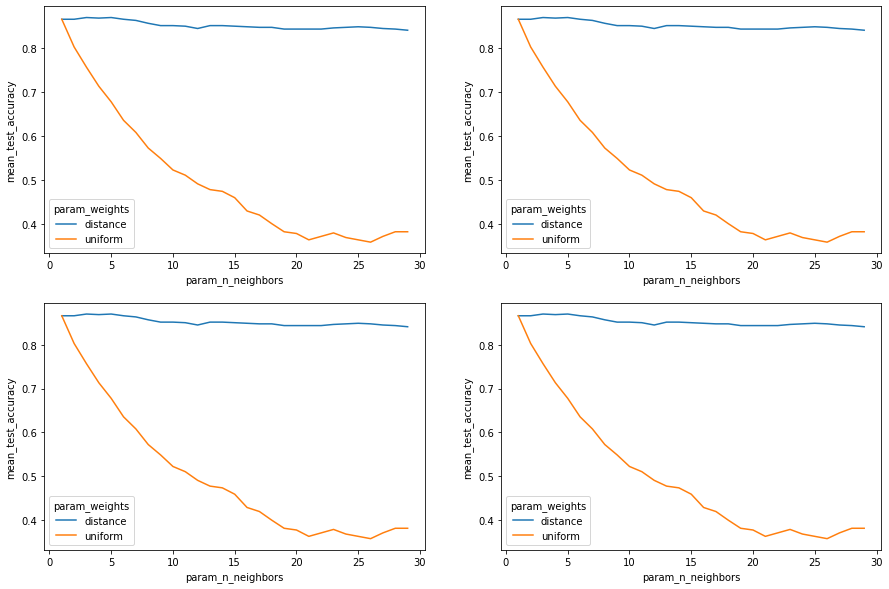

In [60]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))
leaf_size = [i for i in range(1,51,10)]
for i, ax in enumerate(fig.axes):
    sns.lineplot(data = KN_cv_results[KN_cv_results['param_leaf_size']==leaf_size[i]], 
                 x = 'param_n_neighbors', 
                 y = 'mean_test_accuracy',
                 ax = ax, hue = 'param_weights')

- Using `uniform` as weights, the accuracy went down as the number of n_neighbors increases, but with `leaf_size = 1`, and `n_neighbors = 1`, the weights uniform and distances' accuracy do not vary
- `distance` also decreases accuracy but not exponentially unlike `uniform`
- Since all graphs are just the same, `leaf_size` do not affect the performance of the model
- the hyperparamters to be used are weight = uniform with leaf_size = 1 and n_neighbors = 3, and 5

Now let's check the performance to select by plotting the mean fit time

<AxesSubplot:xlabel='mean_test_accuracy', ylabel='mean_fit_time'>

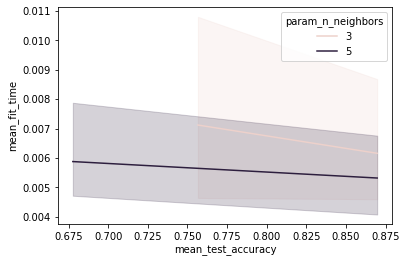

In [99]:
sns.lineplot(data = KN_cv_results[(KN_cv_results['param_n_neighbors']==3) | (KN_cv_results['param_n_neighbors']==5)], 
             x = 'mean_test_accuracy', 
             y = 'mean_fit_time',
             hue = 'param_n_neighbors')

here we will choose 5 as the value of the n_neighbors

In [61]:
KN_final_model.best_params_

{'leaf_size': 1, 'n_neighbors': 3, 'weights': 'distance'}

### Decision Tree Classifier

In [62]:
DT_cv_results = pd.DataFrame(DT_final_model.cv_results_).sort_values(by='rank_test_accuracy')

In [63]:
DT_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_splitter,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
29,0.005798,0.001167,0.004799,0.001835,150,random,"{'max_depth': 150, 'splitter': 'random'}",0.828947,0.894737,0.907895,0.894737,0.947368,0.894737,0.038135,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1
15,0.006200,0.001472,0.006598,0.001855,80,random,"{'max_depth': 80, 'splitter': 'random'}",0.828947,0.894737,0.907895,0.894737,0.947368,0.894737,0.038135,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1
13,0.007199,0.001717,0.005600,0.001625,70,random,"{'max_depth': 70, 'splitter': 'random'}",0.828947,0.894737,0.907895,0.894737,0.947368,0.894737,0.038135,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1
21,0.008401,0.001498,0.009206,0.002222,110,random,"{'max_depth': 110, 'splitter': 'random'}",0.828947,0.894737,0.907895,0.894737,0.947368,0.894737,0.038135,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1
11,0.006796,0.000981,0.006799,0.001468,60,random,"{'max_depth': 60, 'splitter': 'random'}",0.828947,0.894737,0.907895,0.894737,0.947368,0.894737,0.038135,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1,0.820843,0.885374,0.902173,0.886877,0.941506,0.887355,0.038936,1


<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_accuracy'>

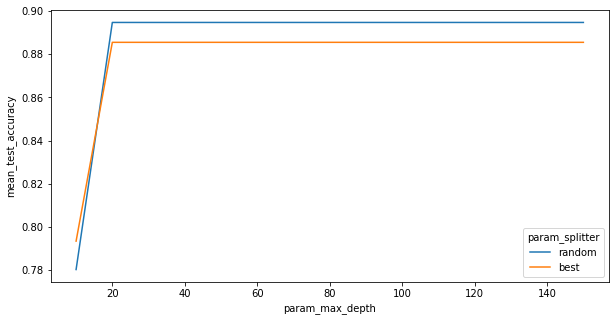

In [64]:
fig = plt.figure(2, figsize=(10, 5))
sns.lineplot(data = DT_cv_results, 
             x = 'param_max_depth', 
             y = 'mean_test_accuracy',
             hue = 'param_splitter')

- the best splitter is random
- the accuracy didn't increase when max_depth values at greater than 20

Let's plot the fit_time, and let's use the max_depth that consumes minimal resources

<AxesSubplot:xlabel='param_max_depth', ylabel='mean_fit_time'>

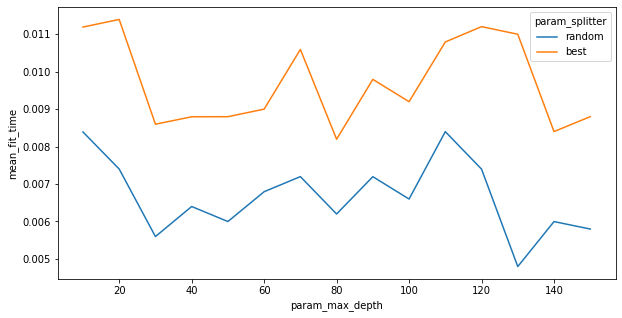

In [65]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data = DT_cv_results, 
             x = 'param_max_depth', 
             y = 'mean_fit_time',
             hue = 'param_splitter')

random also has low fit time and max depth with the lowest fit_time is around 130
Let's use the `max_dept = 130` and `splitter = random`

In [66]:
DT_final_model.best_params_

{'max_depth': 20, 'splitter': 'random'}

### Random Forest

In [67]:
RF_cv_results = pd.DataFrame(RF_final_model.cv_results_).sort_values(by='rank_test_accuracy')

In [68]:
RF_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
74,1.341197,0.136473,0.094000,0.019187,gini,90,300,"{'criterion': 'gini', 'max_depth': 90, 'n_esti...",0.835526,0.881579,0.907895,0.894737,0.960526,0.896053,0.040427,1,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3
65,1.412202,0.238062,0.083998,0.006365,gini,80,300,"{'criterion': 'gini', 'max_depth': 80, 'n_esti...",0.835526,0.881579,0.907895,0.894737,0.960526,0.896053,0.040427,1,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3
38,1.228004,0.058840,0.078796,0.003872,gini,50,300,"{'criterion': 'gini', 'max_depth': 50, 'n_esti...",0.835526,0.881579,0.907895,0.894737,0.960526,0.896053,0.040427,1,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3
83,1.487797,0.281377,0.085205,0.005037,gini,100,300,"{'criterion': 'gini', 'max_depth': 100, 'n_est...",0.835526,0.881579,0.907895,0.894737,0.960526,0.896053,0.040427,1,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3
128,1.535795,0.298072,0.089600,0.012815,gini,150,300,"{'criterion': 'gini', 'max_depth': 150, 'n_est...",0.835526,0.881579,0.907895,0.894737,0.960526,0.896053,0.040427,1,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3,0.817651,0.872156,0.901061,0.883684,0.957652,0.886441,0.045229,3


<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_accuracy'>

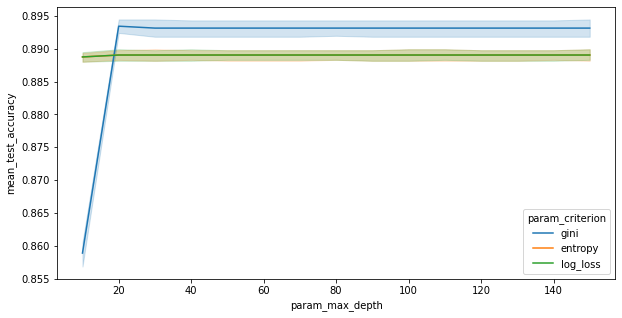

In [69]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data = RF_cv_results, 
             x = 'param_max_depth', 
             y = 'mean_test_accuracy',
             hue = 'param_criterion')

if we didn't plot the n_estimators, log_loss is the best criterion. Also, max_depth values at greater than to 20 didn't improve the performance of the model

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_accuracy'>

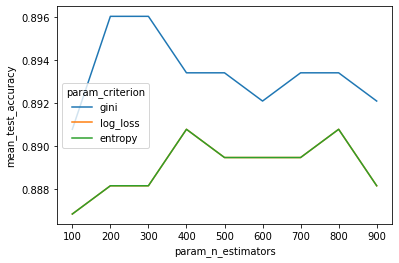

In [70]:
sns.lineplot(data = RF_cv_results[RF_cv_results['param_max_depth']==20], 
             x = 'param_n_estimators', 
             y = 'mean_test_accuracy',
             hue = 'param_criterion')

Here' the gini criterion is the best criterion.Also, n_estimator values at greater than to 300 didn't improve the performance of the model

Now, Let's graph the mean_fit time with respect to n_estimators and max_depth and choose the params with lowest mean fit time

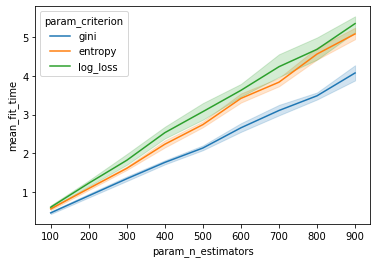

In [71]:
sns.lineplot(data = RF_cv_results, 
             x = 'param_n_estimators', 
             y = 'mean_fit_time',
             hue = 'param_criterion');

We can see here that as the number of n_estimator increases, the fit time also increases, and the log_loss has the largest fit time. Let's try to plot the max depth. And the `n_estimator = 200` has low fitting time

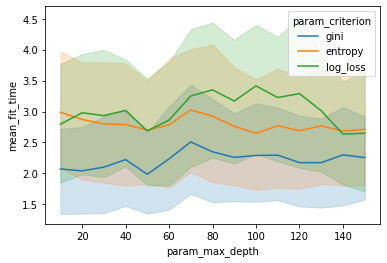

In [72]:
sns.lineplot(data = RF_cv_results, 
             x = 'param_max_depth', 
             y = 'mean_fit_time',
             hue = 'param_criterion');

here, gini with 50 max_depth mean_fit_time is the lowest.
Let's use the following parameters
```
max_depth = 50
criterion = 'gini'
n_estimators = 200
```

In [73]:
RF_final_model.best_params_

{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}

### Gradient Boosting

In [74]:
GB_cv_results = pd.DataFrame(GB_final_model.cv_results_).sort_values(by='rank_test_accuracy')

In [75]:
GB_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
542,6.811797,0.180053,0.015600,0.001494,friedman_mse,0.5,10,300,"{'criterion': 'friedman_mse', 'learning_rate':...",0.855263,0.894737,0.907895,0.914474,0.967105,0.907895,0.036034,1,0.846063,0.890199,0.900583,0.908024,0.965504,0.902075,0.038313,1,0.846063,0.890199,0.900583,0.908024,0.965504,0.902075,0.038313,1
544,10.494800,0.182740,0.018800,0.000979,friedman_mse,0.5,10,500,"{'criterion': 'friedman_mse', 'learning_rate':...",0.855263,0.894737,0.907895,0.907895,0.967105,0.906579,0.035890,2,0.846063,0.890360,0.900583,0.902126,0.965504,0.900927,0.038193,2,0.846063,0.890360,0.900583,0.902126,0.965504,0.900927,0.038193,2
543,8.632400,0.431737,0.017202,0.001165,friedman_mse,0.5,10,400,"{'criterion': 'friedman_mse', 'learning_rate':...",0.855263,0.894737,0.907895,0.907895,0.960526,0.905263,0.033701,3,0.846063,0.890360,0.900583,0.902126,0.957801,0.899386,0.035626,3,0.846063,0.890360,0.900583,0.902126,0.957801,0.899386,0.035626,3
541,5.235800,0.392135,0.015201,0.001469,friedman_mse,0.5,10,200,"{'criterion': 'friedman_mse', 'learning_rate':...",0.848684,0.888158,0.907895,0.914474,0.967105,0.905263,0.038497,3,0.837833,0.882023,0.900479,0.908024,0.965504,0.898773,0.041318,8,0.837833,0.882023,0.900479,0.908024,0.965504,0.898773,0.041318,8
545,11.727401,0.227705,0.019999,0.000896,friedman_mse,0.5,10,600,"{'criterion': 'friedman_mse', 'learning_rate':...",0.855263,0.894737,0.907895,0.901316,0.967105,0.905263,0.035938,3,0.846063,0.890360,0.900583,0.893537,0.965504,0.899209,0.038293,4,0.846063,0.890360,0.900583,0.893537,0.965504,0.899209,0.038293,4


Let's plot first the max depth again

<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_accuracy'>

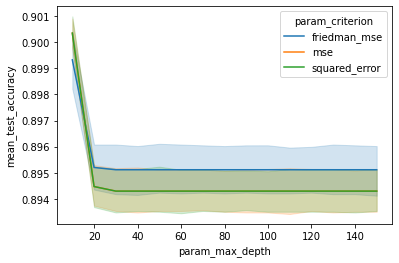

In [76]:
sns.lineplot(data = GB_cv_results,
                     x = 'param_max_depth', 
                     y = 'mean_test_accuracy',
                     hue = 'param_criterion')

max_depth best parameter is 10, let's plot other parameters when the max_depth is 10

<AxesSubplot:xlabel='param_learning_rate', ylabel='mean_test_accuracy'>

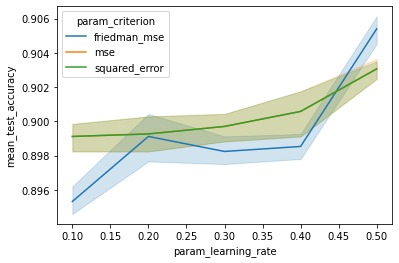

In [77]:
sns.lineplot(data = GB_cv_results[GB_cv_results['param_max_depth']==10],
                     x = 'param_learning_rate', 
                     y = 'mean_test_accuracy',
                     hue = 'param_criterion')

best hyperparameter for learning rate is 0.50 if the criterion is friedman_mse, let's plot 0.50 learning rate

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_accuracy'>

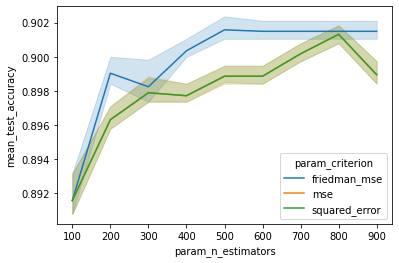

In [109]:
sns.lineplot(data = GB_cv_results[(GB_cv_results['param_learning_rate']==0.50)],
                     x = 'param_n_estimators', 
                     y = 'mean_test_accuracy',
                     hue = 'param_criterion')

The best number of estimators is 500, let's use that

the best parameters are 
```
criterion = 'friedman_mse'
max_depth = 10
n_estimators = 500
learning_rate = 0.4
```

In [79]:
GB_final_model.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.5,
 'max_depth': 10,
 'n_estimators': 300}

In [110]:
final_logreg = LogisticRegression(class_weight= None, multi_class = 'ovr', solver = 'newton-cg', random_state = 42)
final_log_reg_scores = get_metrics(logreg)

final_KNClass = KNeighborsClassifier(leaf_size = 1, n_neighbors = 5, weights = 'distance')
final_KN_scores = get_metrics(KNClass)

final_DTClass = DecisionTreeClassifier(max_depth= 130, splitter= 'random', random_state = 42)
final_DT_scores = get_metrics(DTClass)

final_RFClass = RandomForestClassifier(criterion = 'gini', max_depth = 20, n_estimators = 200, random_state = 42)
final_RF_scores = get_metrics(RFClass)

final_GBClass = GradientBoostingClassifier(criterion = 'friedman_mse', 
                                           max_depth = 10, 
                                           n_estimators = 500,
                                           learning_rate = 0.5, 
                                           random_state = 42)
final_GB_scores = get_metrics(GBClass)

In [111]:
final_scores = [final_log_reg_scores, final_KN_scores, final_DT_scores, final_RF_scores, final_GB_scores]

In [112]:
final_df_score = [make_df_scores(list_ml_algo[i], scores[i]) for i in range(len(scores))]
final_df_score = pd.concat(final_df_score).reset_index().drop(columns='index')
final_df_score

,Machine Learning Algorithm,Fold_Number,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_weighted
0,LogisticRegression,1,0.107008,0.002990,0.430769,0.224799,0.365092
1,LogisticRegression,2,0.022002,0.002999,0.437500,0.246245,0.382530
2,LogisticRegression,3,0.020001,0.002998,0.406250,0.203737,0.345263
3,LogisticRegression,4,0.020965,0.003036,0.406250,0.206250,0.344531
4,LogisticRegression,5,0.019999,0.003003,0.375000,0.165262,0.319677
5,KNeighbor,1,0.002014,0.015961,0.415385,0.271751,0.395806
6,KNeighbor,2,0.002000,0.019039,0.421875,0.277913,0.384909
7,KNeighbor,3,0.002994,0.016006,0.359375,0.215344,0.307341
8,KNeighbor,4,0.001030,0.017962,0.453125,0.295327,0.407067
9,KNeighbor,5,0.002015,0.017987,0.468750,0.299250,0.426723


In [113]:
final_df_score.groupby('Machine Learning Algorithm').mean()

,Fold_Number,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_weighted
Machine Learning Algorithm,,,,,,
DecisionTree,3.0,0.004194,0.003998,0.404952,0.330286,0.407250
GradientBoost,3.0,0.723401,0.003591,0.448702,0.345102,0.437824
KNeighbor,3.0,0.002011,0.017391,0.423702,0.271917,0.384369
LogisticRegression,3.0,0.037995,0.003005,0.411154,0.209259,0.351418
RandomForest,3.0,0.144207,0.014394,0.448798,0.330146,0.431341


**We conclude that the best model was the Random Forest**